The first part of the tutorial is inspired by the single morphometrics analysis proposed in Guijarro et al., 2024 [Github](https://github.com/VILLOUTREIXLab/sc-morphometrics-SHF), [paper](https://www.nature.com/articles/s41467-024-53612-8)

# Single-cell morphometrics reveals T-box dependent patterns of epithelial tension in the Second Heart Field

### Goal: 
Understand the patterning of cardiac progenitors.The embryonic heart grows by the progressive addition of progenitor cells located on an epithelial layer known as the Dorsal pericardial wall (DPW).
T-box transcription genes (Tbx1 and Tbx5) play a key role in regulating the addition of the cells to the poles of the heart. However, the mechanisms by which the cells contribute to each pole remain unclear.

![E8 5 to E9 5 transition horizontal graph v3](https://github.com/user-attachments/assets/ac37731b-2141-4eb7-97a4-b89efddd72b4)
To investigate this, we have employed dimentionality reduction and unsupervised clustering algorythms to map the cells according to their morphological features.

### Data:
- The data used for the sc-morphometricanalysis is stored in the Data folder. The code for quantification of sc-morphometrics clusters is in Quantification clusters - final.ipnyb, the code for the clusters obtained using absolute angle values is in Quantification clusters_abs degrees.ipnyb.
- The data used for RNAscope quantification is stored in Data_RNAscope folder. The code for quantification is RNAscope - mRNA quantification - final.ipnyb
- The images from wild-type, mutants and BMS treatment passed through Tissue Analyser for their segmentation and used in the study are in the IMAGES folder.

### Pipeline:
![figure1](https://github.com/user-attachments/assets/edccac6e-3534-4fe0-8c57-3da490ac7e71)

1) Data acquisition: Whole mount immunofluorescence on the Dorsal pericardial wall (the cardiac epithelium) using phalloidin to label the cell membranes and other proteins of interest.
2) Image segmentation using [Tissue Analyser](https://github.com/baigouy/tissue_analyzer) (TA) as described by Aigouy et al.2016, [Force inference](https://data.mendeley.com/datasets/78ng4tmj75/4) (Kong et al. 2019) and application of [Dproj](https://gitlab.pasteur.fr/iah-public/DeProj) (Herbert et al. 2021).
3) Store,clean and merge the data

In this tutorial, we will analyze the data using joint-spatial PCA 

In [2]:
import pandas as pd
import numpy as np
import copy
import os
from scipy.io import savemat

# data/input folder contains
# 1)all the adjacency matrices as dataframes using the cells names cell_id as indices and columns names
# the adjacency matrices should be named 'Ae'+str(e_id) for each e_id
# 2)the dataframe of all centered and scaled features, called 'df_features_scaled.pkl'
# with a column 'embryo' for e_id of the embryos 


# the scaled features can be found in the following data frame
df_features_scaled=pd.read_pickle('data/scmorphometrics/df_features_scaled.pkl')
e_ids=[1,2,3,4,5,6]
n_features=7

# the positions of individual cells can be found the following data frame
df_abs=pd.read_pickle('data/scmorphometrics/df_positions_labelled_def.pkl')


merged_df = pd.merge(df_features_scaled, df_abs )

# visualize the head
merged_df.head()
# df_features_scaled.head


,area,orientation,perimeter,pressure,theta1N,ratio_lambda,eccentricity,n_neighbors,id_cell,condition,embryo,x,y,label
0,-1.328175,0.702466,-1.531585,0.674994,1.110664,-1.848652,-1.594761,-1.947063,3,E9WT,1,24.975410,817.786885,0
1,2.155923,0.314301,1.912430,-0.290783,0.146127,1.017645,-3.591350,0.316183,4,E9WT,1,33.761795,842.621404,2
2,2.095289,0.644881,1.822805,-1.254467,0.153496,-0.360227,1.238213,-1.192648,5,E9WT,1,37.967290,664.415888,0
3,1.190450,0.506969,1.509251,0.470328,-0.255019,-1.271032,0.267465,1.070598,6,E9WT,1,37.105740,978.809668,2
4,-0.483970,0.176495,-0.593137,-1.216191,0.251175,1.115423,-2.996349,-2.701479,7,E9WT,1,33.696370,626.224422,2


Text(0, 0.5, 'Center Y')

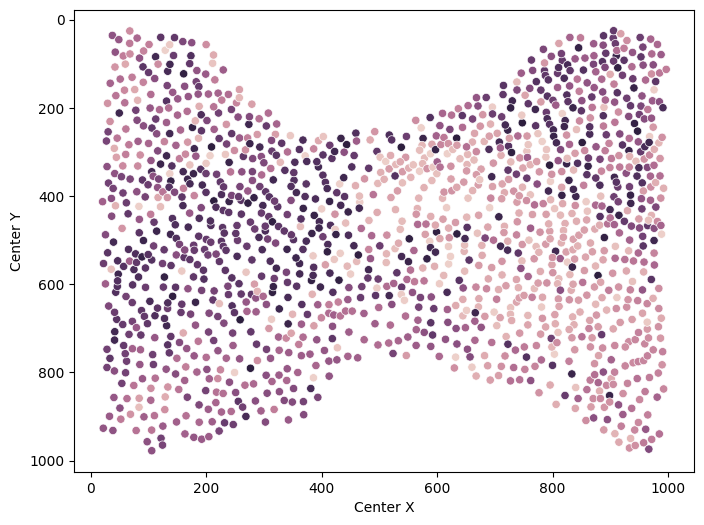

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import show 
import seaborn as sns 

# question 1 - visualize each of the feature in the tissue space for a given embryo

# Adjust the figsize as needed
plt.figure(figsize=(8, 6))

# Create the scatter plot
ax = sns.scatterplot(data=merged_df[merged_df['embryo'] == 6], x="x", y="y",
                     hue='orientation', legend = 0)

# Invert the y-axis
ax.invert_yaxis()

# Set axis labels
ax.set_xlabel('Center X')
ax.set_ylabel('Center Y')


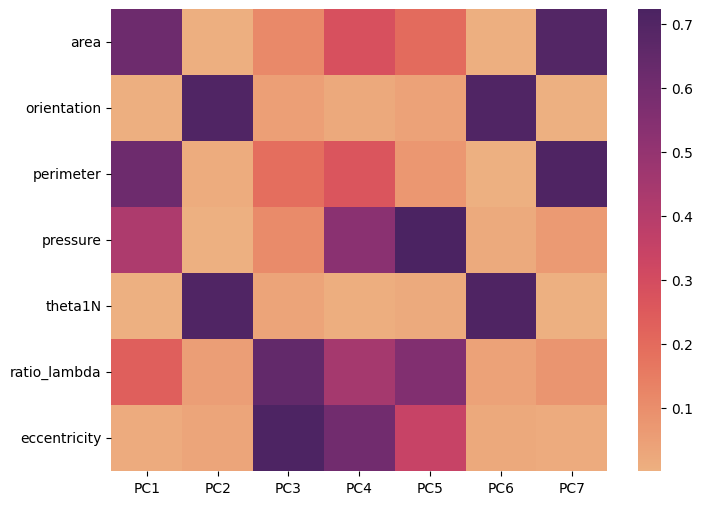

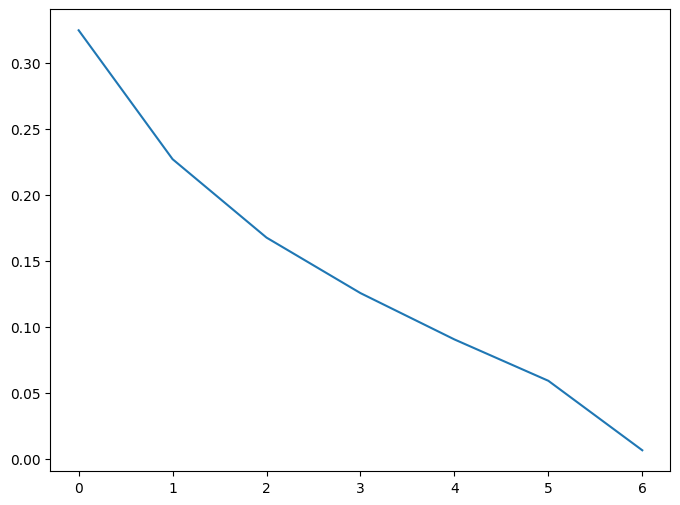

In [4]:
# question 2 - visualize the eigenvalues of the PCA of the scaled features (we will focus on the E9WT embryos and omit the number of neighbors which is discrete value)
from sklearn.decomposition import PCA
import plotly.express as px

#df_features_scaled.head()
#print(df_features_scaled[df_features_scaled['condition'] == 'E9WT'].iloc[:, : 7])

labels = ["area", "orientation", "perimeter", "pressure", "theta1N", "ratio_lambda", "eccentricity"]
pcs = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7"]

pca = PCA(n_components=7)
pca.fit(df_features_scaled.iloc[:, : n_features])

plt.figure(figsize=(8, 6))
df_pca = pd.DataFrame(np.abs(pca.components_.T), index = labels,
                  columns = pcs)
sns.heatmap(df_pca, cmap="flare")


plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_)
#print(pca.explained_variance_)


1


(array([ 18.,  78., 232., 375., 341., 166.,  62.,  15.,   3.,   2.]),
 array([ 2. ,  2.9,  3.8,  4.7,  5.6,  6.5,  7.4,  8.3,  9.2, 10.1, 11. ]),
 <BarContainer object of 10 artists>)

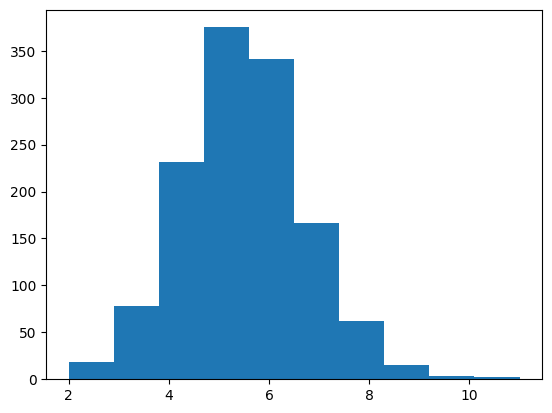

In [5]:
# from the position of the cells, it is possible to compute the adjacency matrix with k-Nearest Neighbor network 
# or Delaunay Triangulation
# here we have the adjacency matrix as an input in the folder data/scmorphometrics
# as dataframes using the cells names cell_id as indices and columns names
# the adjacency matrices are named 'Ae'+str(e_id) for each e_id (embryo id) 

# Adjacency preprocessing
df_list = [];
adjacencies = [];
for e in e_ids:
    # Adjacency preprocessing
    df_features_embryo=df_features_scaled.loc[df_features_scaled['embryo']==e].reset_index(drop=True)
    
    retained_cells=list(df_features_embryo.id_cell)
    df_A=pd.read_pickle('data/scmorphometrics/'+'Ae'+str(e)+'.pkl')
    all_cells=list(df_A.index)
    df_old_A=copy.deepcopy(df_A)
    ####remove the cells with nan values
    cells_not_retained=list(set(all_cells)-set(retained_cells))
    df_A=df_A.drop(columns=cells_not_retained)
    df_A=df_A.drop(cells_not_retained)
    A=np.array(df_A)
    sumA=np.sum(A,axis=1)
    i_0=np.where(sumA==0)[0]
    ind_0=list(df_A.index[i_0])
    while len(ind_0)>0:
        print(len(ind_0))
        ####remove the newly disconnected nodes
        df_A=df_A.drop(columns=ind_0)
        df_A=df_A.drop(ind_0)
        ####remove newly disconnected from df_features
        df_features_embryo=df_features_embryo.drop(df_features_embryo[df_features_embryo['id_cell'].isin(ind_0)].index)
        A=np.array(df_A)
        sumA=np.sum(A,axis=1)
        i_0=np.where(sumA==0)[0]
        ind_0=list(df_A.index[i_0])
        
    adjacencies.append(A)
    df_list.append(df_features_embryo)



# question 3 - compute the degree distribution of a given embryo 
e = 4
counts, bins = np.histogram(np.sum(adjacencies[e],axis=1))
plt.hist(bins[:-1], bins, weights=counts)




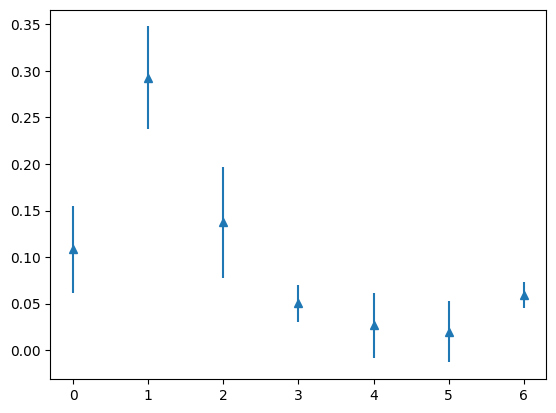

In [6]:
# question 4 (optional) - compute the Moran's Index of the Principal Components using the formulation X^t L X / X^t X

moran_values = np.zeros((len(e_ids),n_features))
for e in range(len(e_ids)):
    # L is the row normalized adjacency matrix
    sumA = np.sum(adjacencies[e],axis=1)
    L = adjacencies[e]/sumA[:,None]


    df_f=df_list[e].drop(['id_cell','condition','embryo'],axis=1)

    # computing the cells new coordinates in the PCA space
    df_new = pca.fit_transform(df_f.iloc[:, : n_features])

    for i in range(df_new.shape[1]):
        moran_values[e,i] = df_new[:,i].T@L@df_new[:,i]/(df_new[:,i].T@df_new[:,i])


plt.errorbar(range(df_new.shape[1]), np.sum(moran_values,axis=0)/len(e_ids), np.std(moran_values,axis=0), linestyle='None', marker='^')
plt.show()

(7, 7)


<Axes: >

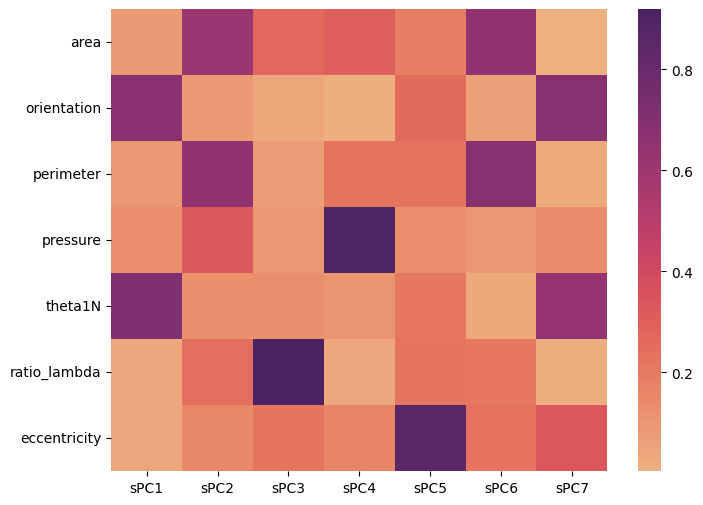

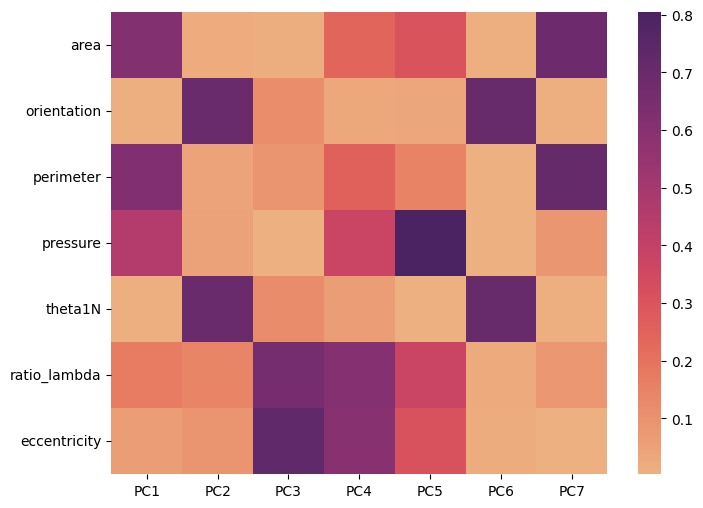

In [7]:
# question 5 - compute sPCA as the eigenvectors of the score matrix (1/2n) X^t(L+L^t)X
# compare the coefficient with the ones obtained with simple PCA

from numpy import linalg as LA

e = 3
# L is the row normalized adjacency matrix
sumA = np.sum(adjacencies[e],axis=1)
L = adjacencies[e]/sumA[:,None]

df_f = df_list[e].drop(['id_cell','condition','embryo'],axis=1)

M = (df_f.iloc[:, : n_features].T@(L+L.T)@df_f.iloc[:, : n_features])/(2*df_f.iloc[:, : n_features].shape[0])

spc_eigenvalues, spc_eigenvectors = LA.eig(M)

print(spc_eigenvectors.shape)

labels = ["area", "orientation", "perimeter", "pressure", "theta1N", "ratio_lambda", "eccentricity"]
spcs = ["sPC1", "sPC2", "sPC3", "sPC4", "sPC5", "sPC6", "sPC7"]

df_spca = pd.DataFrame(np.abs(spc_eigenvectors), index = labels,
                  columns = spcs)

plt.figure(figsize=(8, 6))


sns.heatmap(df_spca, cmap="flare")

plt.figure(figsize=(8, 6))
df_pca = pd.DataFrame(np.abs(pca.components_.T), index = labels,
                  columns = pcs)
sns.heatmap(df_pca,cmap="flare")



(1386,)


/var/folders/1x/9bhbxsx5175_ff8pvp7f74j00000gp/T/ipykernel_31354/982024820.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mask2 = df_list[e]['id_cell'].isin(cells_present[mask1]['id_cell'])
/Users/paul/anaconda3/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


Text(0, 0.5, 'Center Y')

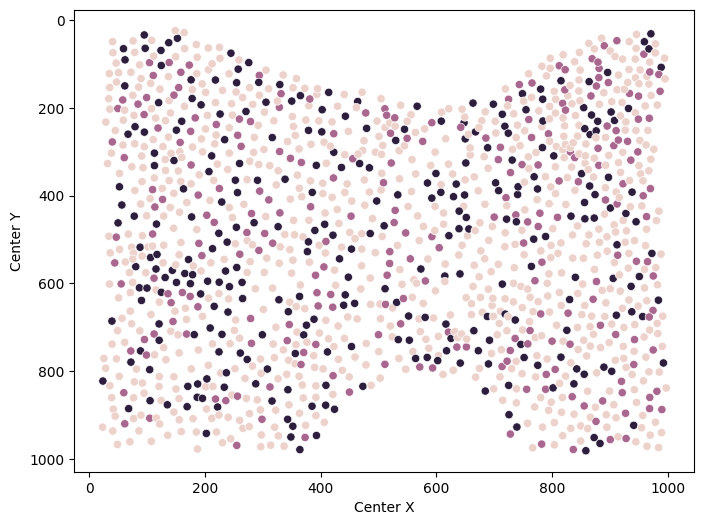

In [8]:
# question 6 - perform 3 class clustering (Gaussian Mixture) on the first component of sPCA and visualize the classes in the tissue space

from sklearn.mixture import GaussianMixture

# first one needs to project the values of each cell for a given embryo on the first component of sPCA (the component with the highest eigenvalue)
projection = df_f.iloc[:, : n_features]@spc_eigenvectors[:,1]

labels = GaussianMixture(n_components=3, random_state=0).fit_predict(projection.values.reshape(-1, 1))

print(labels.shape)

temp = merged_df.loc[merged_df['embryo'] == e]
mask1 = temp['id_cell'].isin(df_list[e]['id_cell'])
cells_present = temp[mask1]
mask2 = df_list[e]['id_cell'].isin(cells_present[mask1]['id_cell'])
cells_present.insert(0, "labels", labels[mask2])

# Adjust the figsize as needed
plt.figure(figsize=(8, 6))

# Create the scatter plot
ax = sns.scatterplot(data=cells_present, x="x", y="y",
                     hue='labels', legend = 0,cmap="flare")

# Invert the y-axis
ax.invert_yaxis()

# Set axis labels
ax.set_xlabel('Center X')
ax.set_ylabel('Center Y')




# Spatial transcriptomics


The second part of the tutorial is dedicated to the spatial analysis of spatial transcriptomics data using [jsPCA](https://github.com/VILLOUTREIXLab/jsPCA/tree/main)

We will base our analysis on the [DLPFC 10x Visium dataset](http://sdmbench.drai.cn), based on slice 151673 (file number 9 in the database).

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
Number of unique labels in 'ground_truth' (excluding NaN) for 151673.h5ad: 7


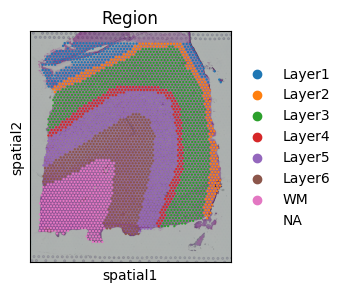

In [34]:
import warnings
import os
import glob
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (normalized_mutual_info_score, 
                             adjusted_rand_score, 
                             accuracy_score,
                             homogeneity_score,
                             completeness_score,
                             silhouette_score)
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import tracemalloc
import time

from sklearn.neighbors import kneighbors_graph

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the folder path where all the .h5ad files are stored
folder_path = "data/visium/"

# # Get a list of all .h5ad files in the folder
# file_paths = glob.glob(os.path.join(folder_path, "*.h5ad"))

# Example: Read the specific .h5ad file (for example, "151673.h5ad")
file_to_read = "151673.h5ad"
adata = ad.read_h5ad(os.path.join(folder_path, file_to_read))
new_adata = ad.read_h5ad(os.path.join(folder_path, file_to_read))

# Display the data
print(adata)

# Normalization
sc.pp.filter_genes(adata,min_cells=20)
sc.experimental.pp.normalize_pearson_residuals(adata)
sc.pp.scale(adata)

# Get the count of unique labels in 'ground_truth', ignoring NaN values
num_labels = adata.obs['ground_truth'].nunique()
print(f"Number of unique labels in 'ground_truth' (excluding NaN) for {file_to_read}: {num_labels}")

# visualize the ground truth data 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Region"], spot_size=100)

In [35]:
# question 1 : Compute the adjacency matrix with k-NN

# first: extract the coordinates
coordinates = adata.obsm['spatial']

# second: compute the k-nn graph with k = 15
k = 50
knn_graph = kneighbors_graph(coordinates, k, mode="distance", include_self=False)

# Add the computed distances and connectivities to the AnnData object
adata.obsp['connectivities'] = knn_graph

In [36]:
# question 2 : Compute the jsPCA monoslice - 1/2n X^t (L + L^t) X - and its eigenvalues and eigenvectors 

# Extract the connectivity matrix from the AnnData object
connectivities = adata.obsp['connectivities'].toarray()
    
# Standardize the connectivities
row_sums = connectivities.sum(axis=1)
L = connectivities / row_sums[:, np.newaxis]

X = adata.X

LLT = 0.5 * (L + L.T)
    
M = np.transpose(X) @ (LLT @ (X))


In [37]:
# question 2 (continued): compute the eigenvalues and eigenvectors

# from numpy import linalg as LA
#spc_eigenvalues, spc_eigenvectors = LA.eig(M)

#do the same with sparse matrices to improve computing time
import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.sparse.linalg import eigsh

# Convert connectivity matrix to sparse CSR format
L_sparse = sp.csr_matrix(L)
X_sparse = adata.X
Xt = X_sparse.T
LLT = 0.5 * (L_sparse + L_sparse.T)

def spca(x):
    return Xt @ (LLT @ (X_sparse @ x))

A = scipy.sparse.linalg.LinearOperator(
    shape=(X_sparse.shape[1], X_sparse.shape[1]), 
    matvec=spca, 
    rmatvec=spca
)

num_eigenvalues = 10
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigsh(A, k=num_eigenvalues)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


In [38]:
# question 3 : Project the data on the first 10 eigenvectors of jsPCA and classify them using Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

X_projected = X_sparse@sorted_eigenvectors

num_labels = adata.obs['ground_truth'].nunique()
gmm = GaussianMixture(n_components=num_labels, random_state=0)
labels = gmm.fit_predict(X_projected)

# Add GMM cluster labels to the AnnData object
adata.obs['GMM_clusters'] = labels
adata.obs['GMM_clusters_Categorical'] = pd.Categorical(labels)


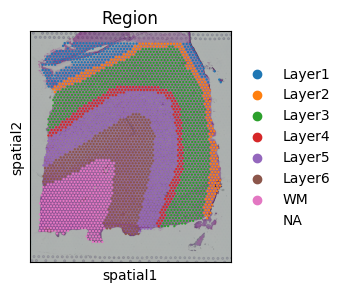

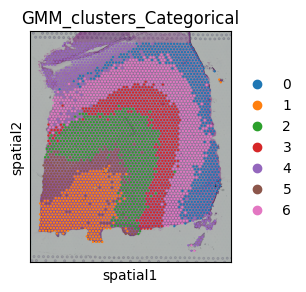

In [39]:
# question 4 : Compare the prediction to the ground truth
# visualize the ground truth data 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Region"], spot_size=100)

# visualize the prediction
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["GMM_clusters_Categorical"], spot_size=100)

In [40]:
# question 4 (bonus): match the colors between the ground truth and the prediction with hungarian algorithm

# Apply Hungarian algorithm for label matching and update AnnData object
gt_key = 'Region'  # Ground truth labels column name

# Drop NaNs before applying the Hungarian algorithm
cluster_labels = adata.obs['GMM_clusters_Categorical']
valid_idx = ~adata.obs[gt_key].isna() & ~cluster_labels.isna()
valid_gt_result = adata.obs[gt_key][valid_idx]
valid_cluster_labels = cluster_labels[valid_idx]


from scipy.optimize import linear_sum_assignment

def apply_hungarian_algorithm(true_labels, cluster_labels):
    """
    Applies the Hungarian algorithm to map cluster labels to true labels.

    Parameters:
        true_labels (array-like): Ground truth labels.
        cluster_labels (array-like): Predicted cluster labels.

    Returns:
        pd.Categorical: Cluster labels mapped to the true label categories.
    """
    # Convert true labels and cluster labels to integer codes using pd.factorize
    true_labels_int, true_labels_categories = pd.factorize(true_labels)
    cluster_labels_int, cluster_labels_categories = pd.factorize(cluster_labels)

    # Generate confusion matrix
    confusion_matrix = np.zeros((len(np.unique(true_labels_int)), len(np.unique(cluster_labels_int))))
    for i, j in zip(true_labels_int, cluster_labels_int):
        confusion_matrix[i, j] += 1

    # Apply the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
    label_mapping = dict(zip(col_ind, row_ind))

    # Map cluster labels back to true labels using the mapping
    mapped_labels = np.array([label_mapping.get(label, -1) for label in cluster_labels_int])

    # Convert mapped labels back to their original categories
    mapped_labels_categories = true_labels_categories[mapped_labels]
    
    return pd.Categorical(mapped_labels_categories, categories=true_labels_categories)

# Apply the Hungarian algorithm for label matching
mapped_labels = apply_hungarian_algorithm(valid_gt_result, valid_cluster_labels)

# Create a full-length array with NaNs in the original NaN positions
full_mapped_labels = np.full(len(adata), np.nan, dtype=object)
full_mapped_labels[valid_idx] = mapped_labels

# Update the AnnData object with the matched cluster labels
adata.obs['GMM_clusters_Hungarian'] = pd.Categorical(full_mapped_labels, categories=adata.obs[gt_key].cat.categories)

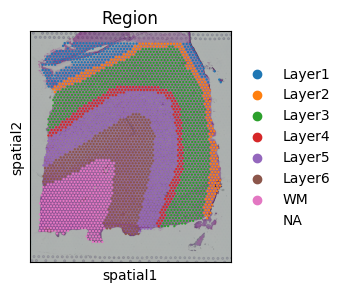

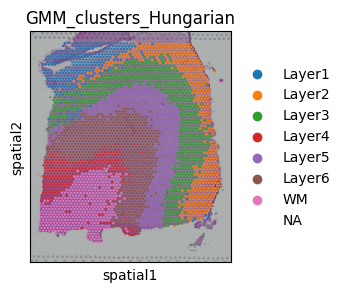

In [42]:
# visualize the prediction with the new colorcode

# visualize the ground truth data 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Region"], spot_size=100)

# visualize the prediction
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["GMM_clusters_Hungarian"], spot_size=100)

In [43]:
# question 5: Compute the ARI (Adjusted Rand Index) and NMI (Normalized Mutual Information)
obs_df = adata.obs.dropna()
ari = adjusted_rand_score(obs_df['GMM_clusters_Hungarian'], obs_df['ground_truth'])
nmi = normalized_mutual_info_score(obs_df['GMM_clusters_Hungarian'], obs_df['ground_truth'])
print(f'ARI: {ari}')
print(f'NMI: {nmi}')

ARI: 0.49692697465030766
NMI: 0.6209475513916535


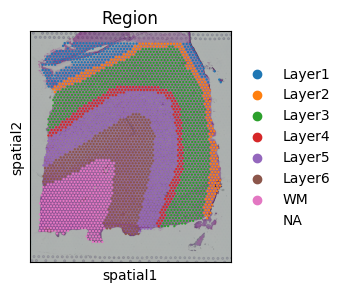

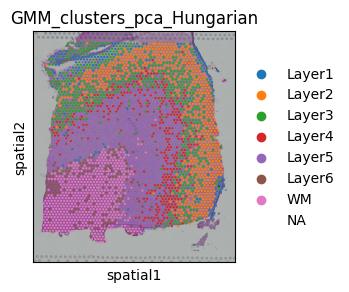

ARI: 0.36180393099704383
NMI: 0.4878615310102688


In [46]:
# question 6: Compare the results with a clustering performed on simple PCA (without taking into account the space)

X = adata.X    
A = np.transpose(X) @ X

num_eigenvalues = 10
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigsh(A, k=num_eigenvalues)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

X_projected = X_sparse@sorted_eigenvectors

num_labels = adata.obs['ground_truth'].nunique()
gmm = GaussianMixture(n_components=num_labels, random_state=0)
labels2 = gmm.fit_predict(X_projected)

# Add GMM cluster pca labels to the AnnData object
adata.obs['GMM_clusters_pca'] = labels2
adata.obs['GMM_clusters_pca_Categorical'] = pd.Categorical(labels2)

gt_key = 'Region'  # Ground truth labels column name

# Drop NaNs before applying the Hungarian algorithm
cluster_labels = adata.obs['GMM_clusters_pca_Categorical']
valid_idx = ~adata.obs[gt_key].isna() & ~cluster_labels.isna()
valid_gt_result = adata.obs[gt_key][valid_idx]
valid_cluster_labels = cluster_labels[valid_idx]

# Apply the Hungarian algorithm for label matching
mapped_labels = apply_hungarian_algorithm(valid_gt_result, valid_cluster_labels)

# Create a full-length array with NaNs in the original NaN positions
full_mapped_labels = np.full(len(adata), np.nan, dtype=object)
full_mapped_labels[valid_idx] = mapped_labels

# Update the AnnData object with the matched cluster labels
adata.obs['GMM_clusters_pca_Hungarian'] = pd.Categorical(full_mapped_labels, categories=adata.obs[gt_key].cat.categories)

# visualize the ground truth data 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Region"], spot_size=100)

# visualize the prediction
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["GMM_clusters_pca_Hungarian"], spot_size=100)

# compute NMI and ARI
obs_df = adata.obs.dropna()
ari = adjusted_rand_score(obs_df['GMM_clusters_pca_Hungarian'], obs_df['ground_truth'])
nmi = normalized_mutual_info_score(obs_df['GMM_clusters_pca_Hungarian'], obs_df['ground_truth'])
print(f'ARI: {ari}')
print(f'NMI: {nmi}')

In [ ]:
# question 7 (optional): compare the results with other spatially aware clustering methods - for example BANKSY -> https://github.com/prabhakarlab/Banksy_py
